# Multiple Linear Regression for Robot Calibration

In this lab, we will illustrate the use of multiple linear regression for calibrating robot control.  In addition to reviewing the concepts in the [multiple linear regression demo](./glucose.ipynb), you will see how to use multiple linear regression for time series data -- an important concept in dynamical systems such as robotics.

The robot data for the lab is taken generously from the TU Dortmund's [Multiple Link Robot Arms Project](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html).  As part of the project, they have created an excellent public dataset: [MERIt](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt) -- A Multi-Elastic-Link Robot Identification Dataset that can be used for understanding robot dynamics.  The data is from a three link robot:

<img src="http://www.rst.e-technik.tu-dortmund.de/cms/Medienpool/redaktionelleBilder/Forschung/Schwerpunkte/TUDOR_engl/TUDORBild.png" height="200" width="200">


We will focus on predicting the current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.

## Load and Visualize the Data
First, import the modules we will need.

In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full MERIt dataset can be obtained from the [MERIt site](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt).  But, this dataset is large.  Included in this repository are two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](./exp1.csv) for training
* [exp2.csv](./exp2.csv) for test

Below, I have supplied the column headers in the `names` array.  Use the `pd.read_csv` command to load the data.  Use the `index_col` option to specify that column 0 (the one with time) is the *index* column.  You can review [simple linear regression demo](..\simp_lin_reg\auto_mpg.ipynb) for examples of using the `pd.read_csv` command.

In [13]:
names =[
    't',                                  # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (A)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
]
# TODO 
# df = pd.read_csv(...)
!pwd
df = pd.read_csv('./exp1.csv', header=None,names=names,na_values='?')

/d/ECE6143/introml/unit03_mult_lin_reg


Print the first six lines of the pandas dataframe and manually check that they match the first rows of the csv file.

In [14]:
# TODO
df.head(6)

,t,q1,q2,q3,dq1,dq2,dq3,I1,I2,I3,eps21,eps22,eps31,eps32,ddq1,ddq2,ddq3
0,0.00,-0.000007,2.4958,-1.1345,-7.882100e-21,-4.940656e-321,3.913100e-29,-0.081623,-0.40812,-0.30609,-269.25,-113.20,3.5918,1.57860,-9.904900e-19,-6.210306e-319,4.917400e-27
1,0.01,-0.000007,2.4958,-1.1345,-2.258200e-21,-4.940656e-321,2.626200e-31,-0.037411,-0.37241,-0.26698,-270.91,-116.05,1.4585,-1.73980,4.248100e-19,-1.766878e-319,-1.381100e-27
2,0.02,-0.000007,2.4958,-1.1345,-6.469800e-22,-4.940656e-321,1.762500e-33,-0.066319,-0.40302,-0.31459,-269.25,-112.97,3.5918,0.86753,3.233800e-19,-4.990557e-320,-4.117300e-28
3,0.03,-0.000007,2.4958,-1.1345,-1.853600e-22,-4.940656e-321,1.182800e-35,-0.068020,-0.43703,-0.28398,-269.97,-114.39,1.6956,-0.08059,1.500500e-19,-1.394253e-320,-1.173100e-28
4,0.04,-0.000007,2.4958,-1.1345,-5.310600e-23,-4.940656e-321,-5.270900e-03,-0.052715,-0.40472,-0.30779,-269.97,-114.15,3.1177,0.86753,5.932400e-20,-3.581976e-321,-3.770800e-01
5,0.05,-0.000007,2.4958,-1.1345,-1.521500e-23,-4.940656e-321,3.252600e-04,-0.088425,-0.42342,-0.29589,-269.25,-114.15,2.4066,-0.08059,2.164600e-20,-1.141292e-321,2.930300e-01


From the dataframe `df`, extract the time indices into a vector `t` and extract `I2`, the current into the second joint.  Place the current in a vector `y` and plot `y` vs. `t`.   Label the axes with the units.

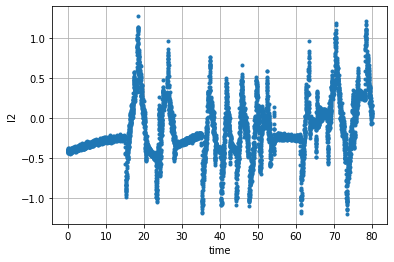

In [15]:
# TODO
# y = ...
# t = ...
# plt.plot(...)
t = df['t']
y = df['I2']
plt.plot(np.array(t), np.array(y), '.')
plt.xlabel('time')
plt.ylabel('I2')
plt.grid()

Use all the samples from the experiment 1 dataset to create the training data:
* `ytrain`:  A vector of all the samples from the `I2` column
* `Xtrain`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`

In [16]:
# TODO
# ytrain = ...
# Xtrain = ...
ytrain = df['I2']
Xtrain = df[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']]
Xtrain.head(6)

,q2,dq2,eps21,eps22,eps31,eps32,ddq2
0,2.4958,-4.940656e-321,-269.25,-113.20,3.5918,1.57860,-6.210306e-319
1,2.4958,-4.940656e-321,-270.91,-116.05,1.4585,-1.73980,-1.766878e-319
2,2.4958,-4.940656e-321,-269.25,-112.97,3.5918,0.86753,-4.990557e-320
3,2.4958,-4.940656e-321,-269.97,-114.39,1.6956,-0.08059,-1.394253e-320
4,2.4958,-4.940656e-321,-269.97,-114.15,3.1177,0.86753,-3.581976e-321
5,2.4958,-4.940656e-321,-269.25,-114.15,2.4066,-0.08059,-1.141292e-321


## Fit a Linear Model
Use the `sklearn.linear_model` module to create a `LinearRegression` class `regr`.

In [17]:
from sklearn import linear_model

# Create linear regression object
# TODO
# regr = ...
regr = linear_model.LinearRegression()


Train the model on the training data.

In [18]:
# TODO
regr.fit(Xtrain,ytrain)
regr.intercept_
regr.coef_

array([ 0.06255018,  0.20584896,  0.00118784,  0.00044457, -0.0031362 ,
        0.00603298,  0.05487097])

Using the trained model, compute, `ytrain_pred`, the predicted current.  Plot `ytrain_pred` vs. time `t`.  On the same plot, plot the actual current `ytrain` vs. time `t`.  Create a legend for the plot.

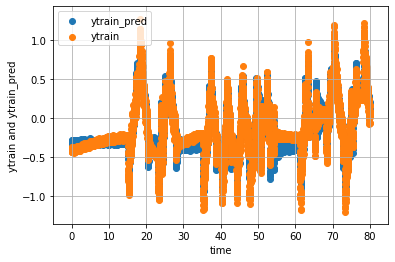

In [43]:
# TODO
# ytrain_pred = ...
# plt.plot(...)
ytrain_pred = regr.predict(Xtrain)
plt.scatter(t,ytrain_pred, label='ytrain_pred')
plt.scatter(t, ytrain, label='ytrain')
# plt.plot([0,1],[0,1],'r')
plt.xlabel('time')
plt.ylabel('ytrain and ytrain_pred')
plt.grid()
plt.legend(loc='upper left')

Measure the normalized RSS given by `RSS / (n s^2_y).

In [20]:
# TODO
# RSS_train = ...
RSS_train = np.mean((ytrain_pred-ytrain)**2)/(np.std(ytrain)**2)
Rsq_train = 1-RSS_train
print("RSS per sample = {0:f}".format(RSS_train))
print("R^2 =            {0:f}".format(Rsq_train))

RSS per sample = 0.095833
R^2 =            0.904167


## Measure the Fit on an Indepdent Dataset

Up to now, we have only tested the model on the same data on which it was trained.  In general, we need to test model on independent data not used in the training.  For this purpose, load the data in `exp2.csv`.  Compute the regression predicted values on this data and plot the predicted and actual values over time.

In [21]:
# TODO
test_df = pd.read_csv('./exp2.csv', header=None,names=names,na_values='?')
test_t = test_df['t']
test_y = test_df['I2']
ytest = test_df['I2']
Xtest = test_df[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']]
Xtest.head(6)
ytest_pred = regr.predict(Xtest)

Measure the normalized RSS on the test data.

In [22]:
# TODO
# RSS_test = ...
y_test_pred = regr.predict(Xtest)
RSS_test = np.mean((ytest_pred-ytest)**2)/(np.std(ytest)**2)
Rsq_test = 1-RSS_test
print("RSS per sample = {0:f}".format(RSS_test))
print("R^2 =            {0:f}".format(Rsq_test))

RSS per sample = 0.126780
R^2 =            0.873220
